# Modelling Antibiotics Resistance through virtual simulations
authors: Talhah Peerbhai (talhah@cmu.edu), Hanna Qasim (hqasim@andrew.cmu.edu)

In [3]:
# Run this to initialize the model
import importlib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Due to the nature of jupyter it doesn't take into account the code outside changing unless kernel restarted
# this is a workaround as per https://stackoverflow.com/questions/64158622/jupyter-does-not-see-changes-in-the-imported-module
imported_module = importlib.import_module("simulation_model.simulation_model")
importlib.reload(imported_module)
from simulation_model.simulation_model import *

params = {
    # Environmental parameters
    "width": 10,
    "height": 10,
    "diffusion_coefficient": 0.01, # nutrients
    "min_nutrients": 200,
    "max_nutrients": 300,
    "nutrient_distribution": "random", # random or uniform, if uniform, every cell gets max_nutrients
    # Bacterium parameters
    "resistant": True,
    "num_agents": 1,
    "nutrient_intake": 6,
    "antibiotic_intake": 1,
    "biomass_threshold": 6,
    "initial_biomass": 2,
    "minimum_biomass": 2,
    "max_in_patch": 4,
    "lag_phase_length": 25,
    "lag_phase_true": True,
    "survival_cost": 1,
    "enzyme_production_rate": 50,
    # Enzyme parameters
    "enzyme_half_life": 100,
    # Kinetic paramaters and Antibiotics
    "antibiotics_coefficient": 0.5, # rate for diffusion
    "antibiotics_diff_enabled": True, # enable disable diffusion
    # options: agent_count, time_step where once a certain amount of agents added or when we reach time step, or disabled
    "add_condition": "disable",
    # options: dense or random
    "add_loc": "dense", 
    "add_time": 40,
    "add_count": 30,
    "add_conc": 1000, # amount of antibiotics to add
    "MIC": 2,
    "v_max": 10,
    "k_m": 1.1,
    # Testing purposes
    "agents_enabled": True,
    # Testing antibiotics doses
    "add_times": [50, 55, 56,60],
}

model = SimModel(params)

/home/talhah/Projects/gcb-antibiotics-sim/simulation_model/simulation_model.py:208: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  nutrient_layer = PropertyLayer("nutrient",self.width,self.height,default_value=0)
/home/talhah/Projects/gcb-antibiotics-sim/simulation_model/simulation_model.py:209: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  antibiotic_layer = PropertyLayer("antibiotic",self.width,self.height,default_value=0)
/home/talhah/Projects/gcb-antibiotics-sim/simulation_model/simulation_model.py:210: UserWarning: Default value 0 (int) might not be best suitable with dtype=float64.
  enzyme_layer = PropertyLayer("enzyme",self.width, self.height, default_value=0)
/home/talhah/Projects/gcb-antibiotics-sim/simulation_model/simulation_model.py:211: UserWarning: Default value -1 (int) might not be best suitable with dtype=float64.
  time_layer = PropertyLayer("time_enzyme",self.width, self.height,default_value=

### View Nutrient distribution

In [ ]:
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["nutrient"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["nutrient"].data[x][y]

print(f"Currently there are {amount} nutrients")
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(15, 15)
g.set(title="Nutrient distribution")

### View Nutrient distribution over time with animation

In [2]:
def update(frame_number, nutrient_counts, model, fig, ax):
    ax.clear()  # Clear current axis to redraw
    amount = 0
    for cell_content, (x, y) in model.grid.coord_iter():
        amount += model.grid.properties["nutrient"].data[x][y]
        nutrient_counts[x,y] = model.grid.properties["nutrient"].data[x][y]
    
    sns.heatmap(nutrient_counts, cmap="viridis", annot=True, 
                cbar=False, square=True, ax=ax)
    
    ax.set(title=f"Nutrient distribution at step {frame_number + 1}\nTotal nutrients: {amount}")

    model.step()

nutrient_counts = np.zeros((model.grid.width, model.grid.height))
fig, ax = plt.subplots(figsize=(6, 6))

# Animation function, range will determine how many steps are taken
ani = FuncAnimation(fig, update, frames=range(50), fargs=(nutrient_counts, model, fig, ax), 
                    interval=200, repeat=False)

plt.close()
#from IPython.display import HTML
#HTML(ani.to_html5_video())
# Save animation, REQUIRES FFMPEG which is standard on most linux distros
ani.save('nutrient_spread.mp4', writer='ffmpeg')
# If this fails then run this and ensure you have pillow with pip install pillow, ask me for help if it still doesn't work
# ani.save('nutrient_spread.gif', writer='pillow')  # Save as GIF

### View Agent distribution

In [ ]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
f = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
f.figure.set_size_inches(4, 4)
f.set(title="Agent Distribution")

### Step Through model

In [ ]:
for _ in range(100):
    model.step()

### View Agent movement and nutrient distribution over time

In [ ]:

def update(frame_number, nutrient_counts, bacteria_locations, model, fig, ax):
    ax.clear()  # Clear current axis to redraw
    nutrient_counts.fill(0)  # Reset nutrient counts to zero for the new frame
    bacteria_locations.fill(0)  # Reset bacteria locations to zero for the new frame
    
    amount = 0
    # Update nutrient counts
    for cell_content, (x, y) in model.grid.coord_iter():
        amount += model.grid.properties["nutrient"].data[x][y]
        nutrient_counts[x, y] = model.grid.properties["nutrient"].data[x][y]
        
    # Update bacteria locations
    for agent in model.schedule.agents:
        if hasattr(agent, 'pos'):  # Ensure agent has a position
            bx, by = agent.pos
            bacteria_locations[bx, by] = 1  # Mark location as occupied by bacteria
    
    # Create a combined plot
    overlay = np.ma.masked_where(bacteria_locations == 0, bacteria_locations) # Mask where there is no bacteria
    sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True, ax=ax)  # Plot for nutrients
    sns.heatmap(overlay, cmap="autumn", annot=False, cbar=False, square=True, ax=ax, alpha=0.6)  # Overlay for bacteria locations
    
    ax.set(title=f"Nutrient distribution and bacteria movement at step {frame_number + 1}\nTotal nutrients: {amount}")
    model.step()

# Assume the `model` is already initiated
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
bacteria_locations = np.zeros_like(nutrient_counts)  # Supplementary array for marking bacteria locations
fig, ax = plt.subplots(figsize=(8, 8))
    
ani = FuncAnimation(fig, update, frames=range(100), fargs=(nutrient_counts, bacteria_locations, model, fig, ax), 
                    interval=200, repeat=False)

plt.close()  # Prevents the final frame plot from showing immediately

# Saving the animation
ani.save('bacteria_nutrient_overlay.mp4', writer='ffmpeg')

#from IPython.display import HTML
#HTML(ani.to_html5_video())

Graph: The red lines in the plot represent the start of each new phase in the bacteria growth cycle. So going from left to right we have: lag, log/exponential, stationary, death.

In [ ]:
def update(frame_number, bacteria_counts, model):
    amount = 0
    for cell_content, (x, y) in model.grid.coord_iter():
        amount += len(cell_content)
        bacteria_counts[frame_number] = amount
    
    model.step()

bacteria_counts = [0]*50

# Call the update function for each frame
for frame_number in range(50):
    update(frame_number, bacteria_counts, model)

# Use the bacteria_counts data from the previous function
time = list(range(0, 50))  # Time points from 0 to 50
bacteria_count = bacteria_counts  # Use the bacteria_counts data from the previous function
phases = ['lag' if t < 5 else 'log' if t < 10 else 'stationary' if t < 30 else 'death' for t in time]  # Different phases of bacterial growth

plt.figure(figsize=(10, 6))

# Plot time against bacteria count
plt.plot(time, bacteria_count, label='Bacteria Count')

# Add vertical lines indicating the start of each phase
for i in range(len(phases)):
    if i > 0 and phases[i] != phases[i-1]:
        plt.axvline(x=time[i], color='r', linestyle='--')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Number of Bacteria')
plt.title('Bacteria Growth Phases')
plt.legend()

# Show the plot
plt.show()


## Plot bacteria growth

Added
Added
Added
Added


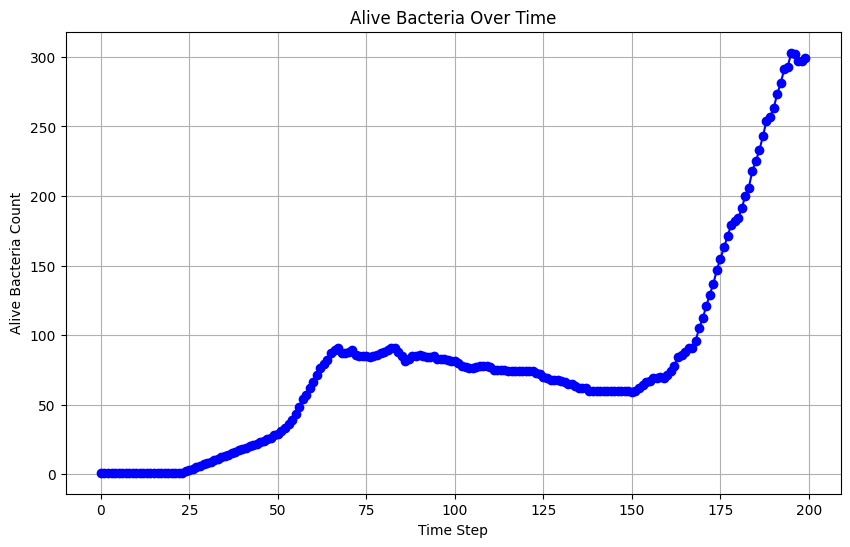

In [66]:
import matplotlib.pyplot as plt

# Assuming `model` is your already initialized model instance from the SimModel class

n_steps = 200  # or any number of steps you intend to simulate
alive_counts_over_time = []
overall_over_time = []

for _ in range(n_steps):
    model.step()
    alive_counts = model.num_agents - model.dead_agents  # Calculate number of alive bacteria
    alive_counts_over_time.append(alive_counts)
    overall_over_time.append(model.num_agents)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(alive_counts_over_time, marker='o', linestyle='-', color='b')
plt.title('Alive Bacteria Over Time')
plt.xlabel('Time Step')
plt.ylabel('Alive Bacteria Count')
plt.grid(True)
plt.show()


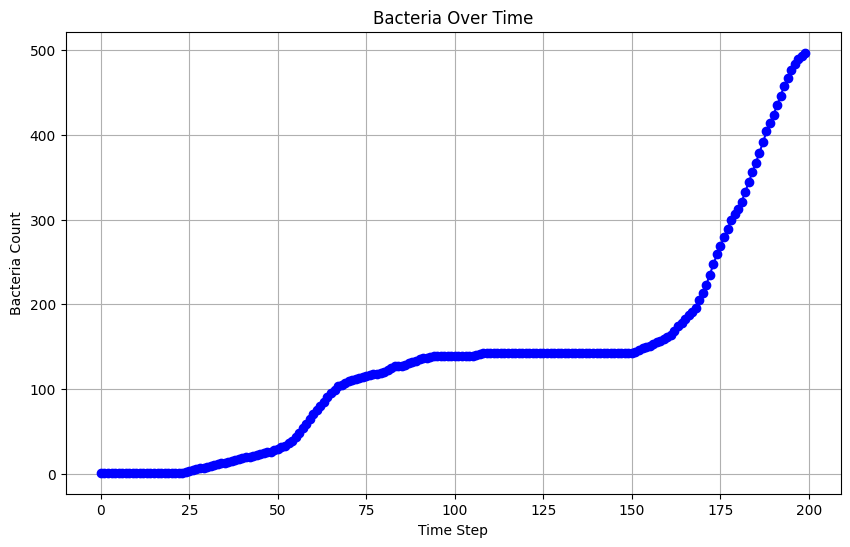

In [67]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(overall_over_time, marker='o', linestyle='-', color='b')
plt.title('Bacteria Over Time')
plt.xlabel('Time Step')
plt.ylabel('Bacteria Count')
plt.grid(True)
plt.show()

## View antibiotic distribution

Currently there are 2.1438908204843483e+59 antibiotics


[Text(0.5, 1.0, 'Antibiotic distribution')]

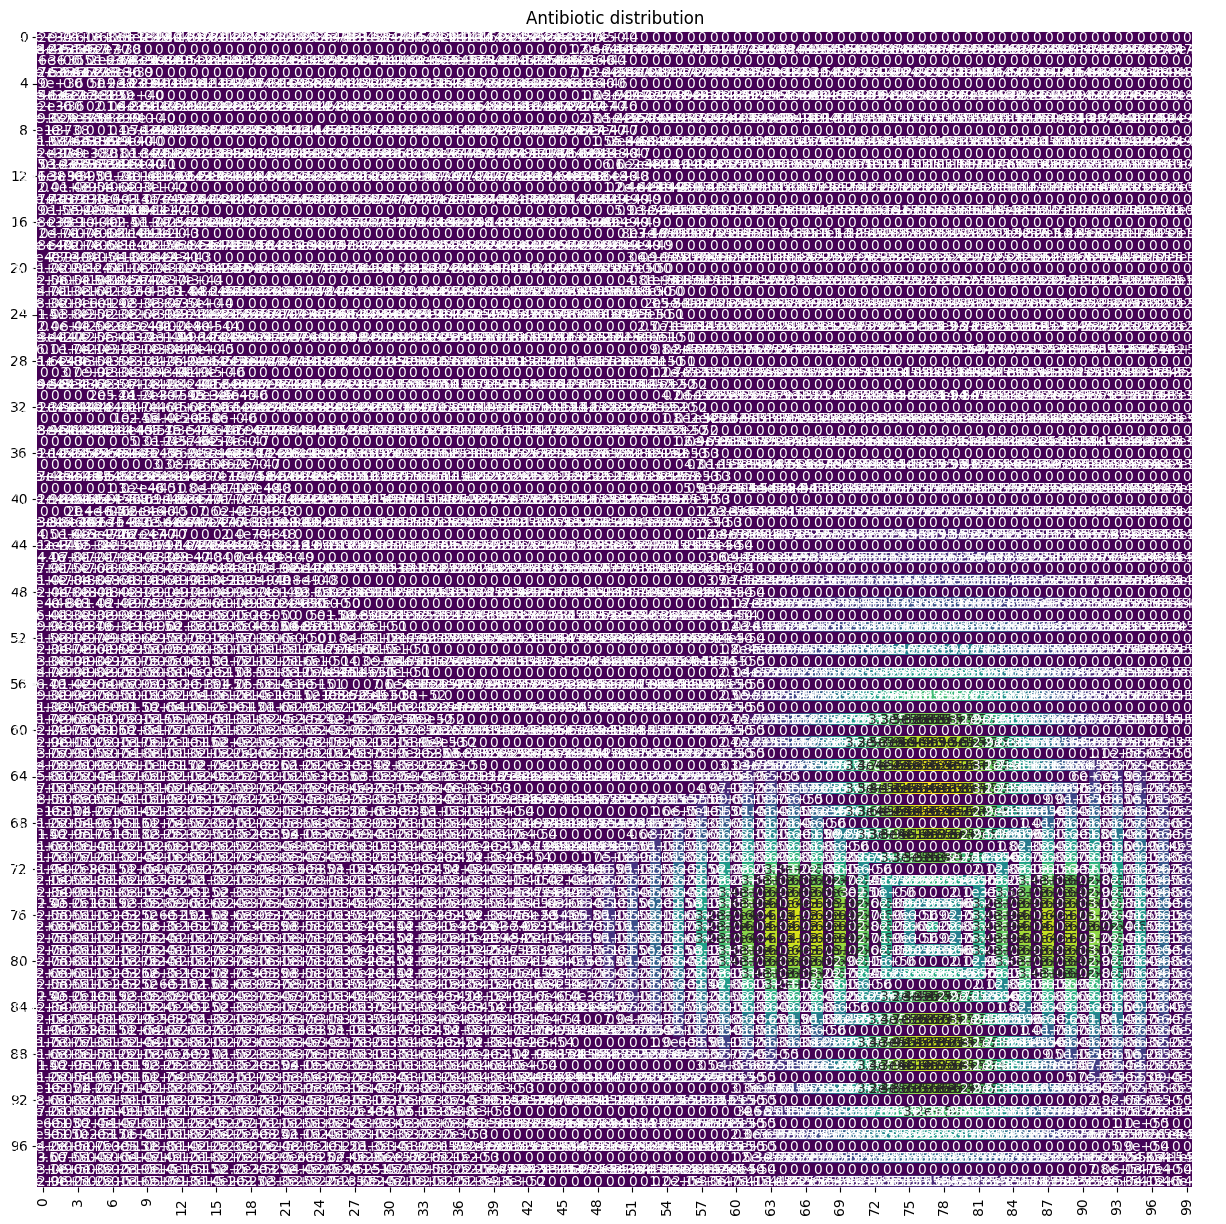

In [68]:
amount = 0
nutrient_counts = np.zeros((model.grid.width, model.grid.height))
for cell_content, (x, y) in model.grid.coord_iter():
    amount += model.grid.properties["antibiotic"].data[x][y]
    nutrient_counts[x][y] = model.grid.properties["antibiotic"].data[x][y]

print(f"Currently there are {amount} antibiotics")
g = sns.heatmap(nutrient_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(15, 15)
g.set(title="Antibiotic distribution")